# Embedding model

In [1]:
import tensorflow as tf
import numpy as np

try:
    if global_run_tests:
        pass
except:
    global_run_tests = True
_embmod_grt = global_run_tests
global_run_tests = False

%run dataset.ipynb
%run visualisation.ipynb
%run tsne.ipynb

global_run_tests = _embmod_grt

_embed_model = None

In [8]:
class EmbeddingModel():
    def __init__(self, dataset, embed_dims):
        self.data       = dataset
        self.embed_dims = embed_dims
        self._session   = None
        self._graph     = None
        self._is_loaded = False
        self._is_built  = False
        self._has_probs = False
        
    def _embedding_nn(self, images, out_dim):
        def conv2d_maxpool(inputs, filters, kernel_size=[3,3], padding="same", activation=tf.nn.relu):
            l = tf.layers.conv2d(
                inputs=inputs,
                filters=filters,
                kernel_size=kernel_size,
                padding=padding,
                activation=tf.nn.relu)
            return tf.layers.max_pooling2d(l, pool_size=[2, 2], strides=2)
        
        l = images
        l = conv2d_maxpool(l, 16)
        l = conv2d_maxpool(l, 32)
        l = conv2d_maxpool(l, 64)
        l = conv2d_maxpool(l, 128)
        l = tf.contrib.layers.flatten(l)
        l = tf.layers.dense(l, units=300, activation=tf.nn.relu)
        l = tf.layers.dense(l, units=out_dim)
        return l
    
    def load_data(self, data_path, data_size):
        self.data.load(data_path, data_size)
        self._is_loaded = True

    def compute_probs(self, batch_size):
        assert self._is_loaded, "Model data is not loaded"        
        samples = np.reshape(self.data.train_images, [-1, np.prod(self.data.image_shape)])
        self.joint_probs = compute_joint_probabilities(
            samples    = samples, 
            batch_size = batch_size)
        self._has_probs = True

    def build(self, batch_size):
        assert self._has_probs, "Probs not computed"
        tf.reset_default_graph()
        self._graph = tf.Graph()
        image_shape = self.data.image_shape
        data_size   = self.data.data_size
        with self._graph.as_default(), tf.name_scope('embedding'), tf.device('/gpu:0'):
            # placeholders
            self.images_pl  = tf.placeholder(dtype=tf.float32, shape=[None,]+image_shape, name='images')
            self.probs_pl   = tf.placeholder(dtype=tf.float32, shape=self.joint_probs.shape[-2:], name='probs')
            self.lr_pl      = tf.placeholder(dtype=tf.float32, name='lr')
            # operations
            self.embed_op   = self._embedding_nn(self.images_pl, self.embed_dims)
            self.loss_op    = tsne_loss(self.probs_pl, batch_size, self.embed_dims, self.embed_op)
            self.train_op   = tf.train.AdamOptimizer(self.lr_pl).minimize(self.loss_op)
            self.init_op    = tf.global_variables_initializer()
        self._is_built = True
        
    def train(self, step_num, batch_size, learning_rate = 1e-4, log_every=10):
        assert self._is_built,  "Model is not built"
        
        if self._session:
            self._session.close()
        
        self._session = tf.Session(graph=self._graph)
        self._session.run(self.init_op)
            
        def get_next_batch(i, bs):
            imgs = self.data.train_images[i:i+bs]
            i = (i + bs) % (self.data.data_size)
            return i, imgs
        
        try:
            losses   = []
            i = 0
            for step in range(step_num):
                pi = i//batch_size
                i, images = get_next_batch(i, batch_size)
                _, loss = self._session.run([self.train_op, self.loss_op], feed_dict={
                    self.images_pl: images,
                    self.probs_pl : self.joint_probs[pi],
                    self.lr_pl    : learning_rate,
                })
                losses.append(loss)
                if step % log_every == log_every-1:
                    show_losses(losses, step, step_num)
        except KeyboardInterrupt:
            pass
        show_losses(losses, step, step_num)

## Test train

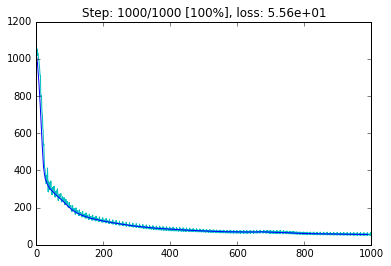

CPU times: user 1min 19s, sys: 35.1 s, total: 1min 54s
Wall time: 1min 22s


In [9]:
%%time
def test_train_model(step_num, data_size, batch_size, learning_rate, embed_dims=7):
    model = EmbeddingModel(Dataset([128,128,1]), embed_dims)
    model.load_data(_dataset_path, data_size)
    model.compute_probs(batch_size)
    model.build(batch_size)
    model.train(step_num, batch_size)
    return model

if global_run_tests:
    _emb_model = test_train_model(step_num=500, data_size=1000, batch_size=100, learning_rate=1e-4)